#LAB 2

##1. Θεωρητικό Μέρος

###1. Παρουσιάστε ένα συγκριτικό πίνακα με τα επίπεδα, το μέγεθος των φίλτρων, συνάρτηση ενεργοποίησης, πλήθος παραμέτρων και τεχνικές pooling και dropout που χρησιμοποιούν

Χαρακτηριστικά | LeNet | AlexNet|VGG
--- | --- | ---|---
Layers | Input: 28x28x1,<br> 4 hidden:<br>H1: 24x24x4<br>H2: 12x12x4<br>H3: 8x8x12<br>H4: 4x4x12<br>Output: 10x1 | Input: 256x256x3<br>5 Convolutional:<br>C1: 55x55x96<br>C2: 27x27x256<br>C3-5: 13x13x384<br>3 Pooling layers:<br>P1: 27x27x96 after C1<br>P2: 13x13x256 after C2<br>P3: 6x6x256 after C5<br>3 fully connected, 2 with<br>4096 neurons, 1 with 1000<br>Output: 1000 softmax neurons|Input: 224x224x3<br>5 blocks of conv layers<br>each followed by pooling<br>3 fully connected, 2 with<br>4096 neurons, 1 with 1000<br>Output: 1000 softmax neurons
Filter Size |5x5 for layers H1 and H3|C1: 11x11x3<br>C2: 5x5x48<br>C3: 3x3x256<br>C4-5: 3x3x192| 3x3 and 1x1 input window
Activation function|Sigmoid|ReLU|ReLU
Number of parameters|2578|around 60 million|133-144 million
Pooling|Average pooling for layers<br>H2 and H4, 2x2 input<br>window, stride 2|Max overlapping pooling<br>with 3x3 input and stride 2|Max pooling with 2x2 input<br>window and stride 2
Dropout|No dropout|Dropout for the first 2<br>fully connected layers|Dropout for the first 2<br>fully connected layers

###2. Ποιες είναι οι βασικές διαφορές στην αρχιτεκτονική και την απόδοση μεταξύ των τριών δικτύων;

####Αρχιτεκτονική

Τα τρία μοντέλα είναι αρκετά διαφορετικά μεταξύ τους. Εκτός από τις διαφορές στη δομή τους, οι οποίες φαίνονται από τον πίνακα του προηγούμενου ερωτήματος, αξίζει να σημειωθεί ότι:
- το LeNet δεν έχει κάποιο κρυφό στρώμα που να είναι fully connected.
- το AlexNet τρέχει σε 2 GPU επεξεργαστές, όπου ο κάθε ένας έχει τους μισούς νευρώνες. Εκτός άλλων, αυτή η αρχιτεκτονική είναι και ελαφρώς πιο γρήγορη στην εκπαίδευση του μοντέλου.
- τα μοντέλα VGG χρησιμοποιούν γενικά μικρά φίλτρα (3x3, 1x1), τα οποία αν χρησιμοποιηθούν σε σειρά μπορούν να 'μιμηθούν' τη συμπεριφορά μεγαλύτερων φίλτρων (5x5, 7x7, 11x11), αλλά με σημαντικά λιγότερες παραμέτρους.

####Απόδοση

Είναι σχετικά δύσκολο να συγκρίνουμε το LeNet με τα άλλα 2 μοντέλα λόγω του ότι είναι σχεδιασμένα για διαφορετικά προβλήματα (το LeNet είναι για digit recognition, ενώ τα άλλα 2 για το ImageNet challenge). Ωστόσο συγκρίνουμε τον χρόνο εκπαίδευσης, και παρουσιάζουμε τα αποτελέσματα του κάθε μοντέλου παρακάτω.

---|LeNet|AlexNet|VGG
---|---|---|---
Training time|about 3 days|between 5-6 days|2-3 weeks

Οι χρόνοι αυτοί δικαιολογούνται από το γεγονός ότι πιο πολύπλοκα μοντέλα χρειάζονται περισσότερο χρόνο για να εκπαιδευτούν, αφού έχουν πολύ περισσότερες παραμέτρους.
Το LeNet πετυχαίνει error rate 3.4% σε όλο το test set.
Για το AlexNet και τα VGG τα καλύτερα αποτελέσματα φαίνονται στον παρακάτω πίνακα.

Error Rate|AlexNet|VGG
---|---|---
Top-1|37.5%|23.7%
Top-5|17.0%|6.8%

Παρατηρούμε ότι τα αποτελέσματα του VGG είναι σημαντικά καλύτερα από αυτά του AlexNet. Ωστόσο ο χρόνος εκπαίδευσης του AlexNet είναι 3 φορές μικρότερος από του VGG.

##2. Υλοποίηση Αλγορίθμου

### Εισαγωγή και επισκόπηση του συνόλου δεδομένων

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)


In [ ]:
# load the entire dataset
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

169001437/169001437 [==============================] - 3s 0us/step


In [ ]:
print(x_train_all.shape)

(50000, 32, 32, 3)


Η κάθε ομάδα θα δουλέψει με διαφορετικό υποσύνολο του dataset.
Στο επόμενο κελί, αντικαταστήστε την τιμή της μεταβλητής `team_seed` με τον αριθμό που αντιστοιχεί στην ομάδας σας.

In [ ]:
# REPLACE WITH YOUR TEAM NUMBER
team_seed = 55

In [ ]:
# select from CIFAR100 20 classes
cifar100_classes_url = "https://pastebin.com/raw/nzE1n98V"

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [ ]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [ ]:
# print our classes
print(our_classes)

[' baby', ' bee', ' caterpillar', ' cockroach', ' crab', ' dinosaur', ' girl', ' leopard', ' lobster', ' mushroom', ' otter', ' pickup_truck', ' poppy', ' rabbit', ' seal', ' squirrel', ' sunflower', ' table', ' tiger', ' wolf']


In [ ]:
print(x_train_ds[1].shape)

(32, 32, 3)


Train: X=(8500, 32, 32, 3), y=(8500, 1)
Validation: X=(1500, 32, 32, 3), y=(1500, 1)
Test: X=(2000, 32, 32, 3), y=(2000, 1)


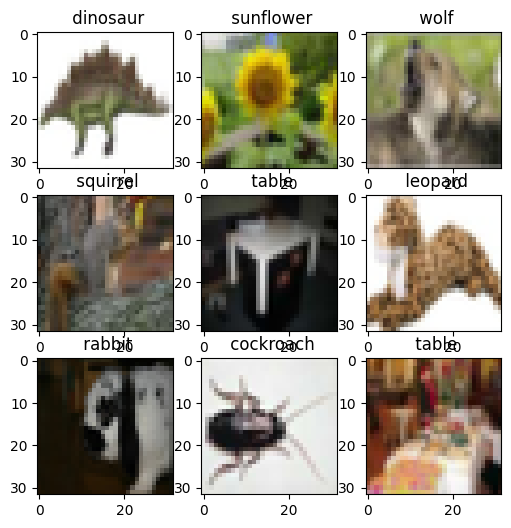

In [ ]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

### Ερώτημα 1
---
#### Βήμα 1: Σχεδίαση, μεταγλώττιση και εκπαίδευση των μοντέλων

 1. Σχεδίαστε, μεταγλωττίστε και εκπαιδεύστε τα μοντέλα  **LeNet, AlexNet και  VGG**, καθώς και ένα δικό σας μοντέλο (ονομάστε το π.χ. **MyCNN**) χρησιμοποιώντας διαφορετικούς συνδυασμούς (τουλάχιστον 2 ανά μοντέλο) για [optimizer](https://keras.io/api/optimizers/), [loss](https://keras.io/api/losses/), batch size και epoch.  Για [metrics](https://keras.io/api/metrics/) να χρησιμοποιήσετε την ορθότητα - accuracy.
---
  
#### Βήμα 2: Αξιολόγηση των μοντέλων

1. Για κάθε ένα από τα μοντέλα που εκπαιδεύσατε, απεικονίστε σε κοινό διάγραμμα την ορθότητα εκπαίδευσης και την ορθότητα επικύρωσης στο σύνολο των εποχών, για κάθε διαφορετικό συνδυασμό του βήματος 1 και επιλέξτε αυτό με την καλύτερη ορθότητα από κάθε μοντέλο (ένα από κάθε αρχιτεκτονική, συνολικά 4).
2. Για κάθε ένα από τα μοντέλα με την καλύτερη ορθότητα (συνολικά **4**), απεικονίστε σε κοινό διάγραμμα την ορθότητα εκπαίδευσης και την ορθότητα επικύρωσης στο σύνολο των εποχών.
3. Αξιολογήστε, αναλυτικά, τα αποτελέσματά σας ως προς τα εξής:
 - Επίδραση του πλήθους των δεδομένων/κλάσεων στην απόδοση του μοντέλου
 - Επίδραση του αλγόριθμου βελτιστοποίησης (optimizer)
 - Επίδραση του μεγέθους δέσμης (batch size)

---

#### Βήμα 3: Αξιολόγηση ορθότητας
Αξιολογήστε την ορθότητα για το test set σας.


### Σχεδίαση

In [ ]:
import numpy as np

values = np.unique(y_val)
values = np.sort(values)

y_val_to20 = np.zeros(len(y_val), dtype=int)
for i in range (y_val.shape[0]):
  y_val_to20[i] =  np.where(values == y_val[i])[0][0]

y_train_to20 = np.zeros(len(y_train), dtype=int)
for i in range (y_train.shape[0]):
  y_train_to20[i] =  np.where(values == y_train[i])[0][0]

y_test_to20 = np.zeros(len(y_test), dtype=int)
for i in range (y_test.shape[0]):
  y_test_to20[i] =  np.where(values == y_test[i])[0][0]

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

#### LeNet

Παρακάτω στήνουμε μια παραλλαγή του LeNet όπως παρουσιάζεται στην υλοποίηση που μας δόθηκε, το οποίο δεν είναι πλέον για αναγνώριση ψηφίων, αλλά για το classification των εικόνων που μας δίνονται. Κάποιες αλλαγές του μοντέλου είναι η διάσταση του επιπέδου εισόδου, του επιπέδου εξόδου, αλλά και η προσθήκη κάποιων fully connected layers.

In [ ]:
def LeNet():
  model = models.Sequential()
  model.add(layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.AvgPool2D(pool_size=2, strides=2))
  model.add(layers.Conv2D(filters=16, kernel_size=5, activation='sigmoid'))
  model.add(layers.AvgPool2D(pool_size=2, strides=2))
  model.add(layers.Flatten())
  model.add(layers.Dense(120, activation='sigmoid'))
  model.add(layers.Dense(84, activation='sigmoid'))
  model.add(layers.Dense(20))
  return model

In [ ]:
X = tf.random.uniform((1, 32, 32, 3))
for layer in LeNet().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)
LeNet_model_1 = LeNet()
LeNet_model_2 = LeNet()
LeNet_model_1.summary()

Conv2D output shape: 	 (1, 32, 32, 6)
AveragePooling2D output shape: 	 (1, 16, 16, 6)
Conv2D output shape: 	 (1, 12, 12, 16)
AveragePooling2D output shape: 	 (1, 6, 6, 16)
Flatten output shape: 	 (1, 576)
Dense output shape: 	 (1, 120)
Dense output shape: 	 (1, 84)
Dense output shape: 	 (1, 20)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d_2 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)          

#### AlexNet

Παρακάτω φτιάχνουμε ένα μοντέλο AlexNet προσαρμοσμένο για το πρόβλημά μας (με διάσταση εισόδου 32x32x3 αντί 256x256x3, και διάσταση εξόδου 20x1 αντί 1000x1).

In [ ]:
def AlexNet():
  model = models.Sequential()
  model.add(layers.Conv2D(filters=96, kernel_size=3, strides=2, activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPool2D(pool_size=3, strides=2))
  model.add(layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'))
  model.add(layers.MaxPool2D(pool_size=3, strides=2))
  model.add(layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'))
  model.add(layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'))
  model.add(layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
  model.add(layers.MaxPool2D(pool_size=3, strides=2))
  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(20))
  return model

In [ ]:
X = tf.random.uniform((1, 32, 32, 3))
for layer in AlexNet().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)
AlexNet_model_1 = AlexNet()
AlexNet_model_2 = AlexNet()
AlexNet_model_1.summary()

Conv2D output shape: 	 (1, 15, 15, 96)
MaxPooling2D output shape: 	 (1, 7, 7, 96)
Conv2D output shape: 	 (1, 7, 7, 256)
MaxPooling2D output shape: 	 (1, 3, 3, 256)
Conv2D output shape: 	 (1, 3, 3, 384)
Conv2D output shape: 	 (1, 3, 3, 384)
Conv2D output shape: 	 (1, 3, 3, 256)
MaxPooling2D output shape: 	 (1, 1, 1, 256)
Flatten output shape: 	 (1, 256)
Dense output shape: 	 (1, 4096)
Dropout output shape: 	 (1, 4096)
Dense output shape: 	 (1, 4096)
Dropout output shape: 	 (1, 4096)
Dense output shape: 	 (1, 20)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 15, 15, 96)        2688      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 96)         0         
 2D)                                                             
                                                                 

#### VGG

Παρακάτω φτιάχνουμε ένα μοντέλο VGG προσαρμοσμένο για το πρόβλημά μας (με διάσταση εισόδου 32x32x3 αντί 224x224x3, και διάσταση εξόδου 20x1 αντί 1000x1).

In [ ]:
def VGG_block(num_convs, num_channels):
  block = models.Sequential()
  for _ in range(num_convs):
    block.add(layers.Conv2D(num_channels, kernel_size=3, padding='same', activation='relu'))
  block.add(layers.MaxPool2D(pool_size=2, strides=2))
  return block

In [ ]:
def VGG(conv_arch):
  model = models.Sequential()
  model.add(layers.Conv2D(conv_arch[0][1], kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
  # The convulational part
  for (num_convs, num_channels) in conv_arch:
      model.add(VGG_block(num_convs, num_channels))
  # The fully-connected part
  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(20))
  return model

In [ ]:
conv_arch = ((1, 64), (1, 128), (2, 256))
X = tf.random.uniform((1, 32, 32, 3))
for layer in VGG(conv_arch).layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)
VGG_model_1 = VGG(conv_arch)
VGG_model_2 = VGG(conv_arch)
VGG_model_1.summary()

Conv2D output shape: 	 (1, 32, 32, 64)
Sequential output shape: 	 (1, 16, 16, 64)
Sequential output shape: 	 (1, 8, 8, 128)
Sequential output shape: 	 (1, 4, 4, 256)
Flatten output shape: 	 (1, 4096)
Dense output shape: 	 (1, 4096)
Dropout output shape: 	 (1, 4096)
Dense output shape: 	 (1, 4096)
Dropout output shape: 	 (1, 4096)
Dense output shape: 	 (1, 20)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 sequential_11 (Sequential)  (None, 16, 16, 64)        36928     
                                                                 
 sequential_12 (Sequential)  (None, 8, 8, 128)         73856     
                                                                 
 sequential_13 (Sequential)  (None, 4, 4, 256)         885248    
                     

#### MyCNN

Για το μοντέλο μας επιλέγουμε κάτι μεταξύ του LeNet και του AlexNet. Αποτελείται από 3 Convolutional layers ακολουθούμενα από pooling layer, και στη συνέχεια 2 fully connected layers. Επιπλέον κάνουμε χρήση dropout.

In [ ]:
def MyCNN():
  model = models.Sequential()
  model.add(layers.Conv2D(filters=96, kernel_size=3, strides=2, activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPool2D(pool_size=3, strides=2))
  model.add(layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'))
  model.add(layers.MaxPool2D(pool_size=3, strides=2))
  model.add(layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'))
  model.add(layers.MaxPool2D(pool_size=3, strides=2))
  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(20))
  return model

In [ ]:
X = tf.random.uniform((1, 32, 32, 3))
for layer in MyCNN().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)
MyCNN_model_1 = MyCNN()
MyCNN_model_2 = MyCNN()
MyCNN_model_1.summary()

Conv2D output shape: 	 (1, 15, 15, 96)
MaxPooling2D output shape: 	 (1, 7, 7, 96)
Conv2D output shape: 	 (1, 7, 7, 256)
MaxPooling2D output shape: 	 (1, 3, 3, 256)
Conv2D output shape: 	 (1, 3, 3, 384)
MaxPooling2D output shape: 	 (1, 1, 1, 384)
Flatten output shape: 	 (1, 384)
Dense output shape: 	 (1, 4096)
Dropout output shape: 	 (1, 4096)
Dense output shape: 	 (1, 20)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 15, 15, 96)        2688      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 7, 7, 96)         0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 7, 7, 256)         614656    
                                                                 
 max_poo

### Μεταγλώτιση και Εκπαίδευση

In [ ]:
# optimizers = ["SGD", "RMSprop", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "Ftrl"]

In [ ]:
LeNet_model_1.compile(optimizer="SGD",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

LeNet_history_1 = LeNet_model_1.fit(x_train, y_train_to20, epochs=10, batch_size=10,
                    validation_data=(x_val, y_val_to20))

Epoch 1/10
850/850 [==============================] - 13s 14ms/step - loss: 3.0077 - accuracy: 0.0471 - val_loss: 3.0011 - val_accuracy: 0.0493
Epoch 2/10
850/850 [==============================] - 8s 10ms/step - loss: 3.0025 - accuracy: 0.0479 - val_loss: 3.0054 - val_accuracy: 0.0507
Epoch 3/10
850/850 [==============================] - 8s 10ms/step - loss: 3.0027 - accuracy: 0.0452 - val_loss: 3.0051 - val_accuracy: 0.0493
Epoch 4/10
850/850 [==============================] - 8s 9ms/step - loss: 3.0016 - accuracy: 0.0501 - val_loss: 2.9961 - val_accuracy: 0.0533
Epoch 5/10
850/850 [==============================] - 9s 10ms/step - loss: 3.0017 - accuracy: 0.0479 - val_loss: 3.0019 - val_accuracy: 0.0420
Epoch 6/10
850/850 [==============================] - 8s 10ms/step - loss: 3.0026 - accuracy: 0.0454 - val_loss: 3.0033 - val_accuracy: 0.0440
Epoch 7/10
850/850 [==============================] - 8s 9ms/step - loss: 3.0020 - accuracy: 0.0493 - val_loss: 3.0056 - val_accuracy: 0.0487


In [ ]:
LeNet_model_2.compile(optimizer="RMSprop",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

LeNet_history_2 = LeNet_model_2.fit(x_train, y_train_to20, epochs=10, batch_size=10,
                    validation_data=(x_val, y_val_to20))

Epoch 1/10
850/850 [==============================] - 9s 10ms/step - loss: 2.9659 - accuracy: 0.0704 - val_loss: 2.8241 - val_accuracy: 0.1133
Epoch 2/10
850/850 [==============================] - 9s 10ms/step - loss: 2.7484 - accuracy: 0.1369 - val_loss: 2.6526 - val_accuracy: 0.1540
Epoch 3/10
850/850 [==============================] - 9s 10ms/step - loss: 2.6463 - accuracy: 0.1652 - val_loss: 2.5989 - val_accuracy: 0.1707
Epoch 4/10
850/850 [==============================] - 8s 9ms/step - loss: 2.5840 - accuracy: 0.1816 - val_loss: 2.5412 - val_accuracy: 0.1807
Epoch 5/10
850/850 [==============================] - 9s 10ms/step - loss: 2.5283 - accuracy: 0.2031 - val_loss: 2.5303 - val_accuracy: 0.2160
Epoch 6/10
850/850 [==============================] - 9s 10ms/step - loss: 2.4761 - accuracy: 0.2218 - val_loss: 2.4727 - val_accuracy: 0.2253
Epoch 7/10
850/850 [==============================] - 9s 10ms/step - loss: 2.4124 - accuracy: 0.2442 - val_loss: 2.3627 - val_accuracy: 0.2573


In [ ]:
AlexNet_model_1.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

AlexNet_history_1 = AlexNet_model_1.fit(x_train, y_train_to20, epochs=15, batch_size=64,
                    validation_data=(x_val, y_val_to20))

Epoch 1/15
133/133 [==============================] - 118s 876ms/step - loss: 2.8459 - accuracy: 0.0884 - val_loss: 2.7205 - val_accuracy: 0.1227
Epoch 2/15
133/133 [==============================] - 115s 863ms/step - loss: 2.7037 - accuracy: 0.1238 - val_loss: 2.6326 - val_accuracy: 0.1140
Epoch 3/15
133/133 [==============================] - 124s 931ms/step - loss: 2.6347 - accuracy: 0.1426 - val_loss: 2.5323 - val_accuracy: 0.1760
Epoch 4/15
133/133 [==============================] - 118s 887ms/step - loss: 2.5185 - accuracy: 0.1914 - val_loss: 2.4297 - val_accuracy: 0.1973
Epoch 5/15
133/133 [==============================] - 118s 889ms/step - loss: 2.3868 - accuracy: 0.2328 - val_loss: 2.2730 - val_accuracy: 0.2740
Epoch 6/15
133/133 [==============================] - 120s 901ms/step - loss: 2.2687 - accuracy: 0.2773 - val_loss: 2.2839 - val_accuracy: 0.2693
Epoch 7/15
133/133 [==============================] - 119s 893ms/step - loss: 2.1574 - accuracy: 0.3129 - val_loss: 2.1364 -

In [ ]:
AlexNet_model_2.compile(optimizer="RMSprop",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

AlexNet_history_2 = AlexNet_model_2.fit(x_train, y_train_to20, epochs=15, batch_size=64,
                    validation_data=(x_val, y_val_to20))

Epoch 1/15
133/133 [==============================] - 119s 890ms/step - loss: 2.9364 - accuracy: 0.0669 - val_loss: 2.8981 - val_accuracy: 0.0907
Epoch 2/15
133/133 [==============================] - 116s 874ms/step - loss: 2.7727 - accuracy: 0.1102 - val_loss: 2.6508 - val_accuracy: 0.1353
Epoch 3/15
133/133 [==============================] - 116s 871ms/step - loss: 2.6749 - accuracy: 0.1364 - val_loss: 2.5163 - val_accuracy: 0.1733
Epoch 4/15
133/133 [==============================] - 115s 866ms/step - loss: 2.5763 - accuracy: 0.1728 - val_loss: 2.4534 - val_accuracy: 0.2053
Epoch 5/15
133/133 [==============================] - 115s 868ms/step - loss: 2.4768 - accuracy: 0.2059 - val_loss: 2.3738 - val_accuracy: 0.2360
Epoch 6/15
133/133 [==============================] - 117s 877ms/step - loss: 2.3681 - accuracy: 0.2473 - val_loss: 2.2971 - val_accuracy: 0.2667
Epoch 7/15
133/133 [==============================] - 115s 863ms/step - loss: 2.2529 - accuracy: 0.2867 - val_loss: 2.1990 -

In [ ]:
VGG_model_1.compile(optimizer='RMSprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

VGG_history_1 = VGG_model_1.fit(x_train, y_train_to20, epochs=30, batch_size=128,
                    validation_data=(x_val, y_val_to20))

Epoch 1/20
67/67 [==============================] - 173s 3s/step - loss: 2.9448 - accuracy: 0.0719 - val_loss: 2.8633 - val_accuracy: 0.1147
Epoch 2/20
67/67 [==============================] - 173s 3s/step - loss: 2.7984 - accuracy: 0.1094 - val_loss: 2.7341 - val_accuracy: 0.1213
Epoch 3/20
67/67 [==============================] - 174s 3s/step - loss: 2.6530 - accuracy: 0.1658 - val_loss: 2.5939 - val_accuracy: 0.1693
Epoch 4/20
67/67 [==============================] - 175s 3s/step - loss: 2.4891 - accuracy: 0.2185 - val_loss: 2.4940 - val_accuracy: 0.1893
Epoch 5/20
67/67 [==============================] - 170s 3s/step - loss: 2.3855 - accuracy: 0.2551 - val_loss: 2.4244 - val_accuracy: 0.2120
Epoch 6/20
67/67 [==============================] - 171s 3s/step - loss: 2.2686 - accuracy: 0.2828 - val_loss: 2.2063 - val_accuracy: 0.2887
Epoch 7/20
67/67 [==============================] - 172s 3s/step - loss: 2.1471 - accuracy: 0.3273 - val_loss: 2.0602 - val_accuracy: 0.3367
Epoch 8/20
67

In [ ]:
VGG_model_2.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

VGG_history_2 = VGG_model_2.fit(x_train, y_train_to20, epochs=20, batch_size=128,
                    validation_data=(x_val, y_val_to20))

Epoch 1/20
67/67 [==============================] - 177s 3s/step - loss: 2.9348 - accuracy: 0.0793 - val_loss: 2.6935 - val_accuracy: 0.1620
Epoch 2/20
67/67 [==============================] - 172s 3s/step - loss: 2.5600 - accuracy: 0.2071 - val_loss: 2.4371 - val_accuracy: 0.2240
Epoch 3/20
67/67 [==============================] - 175s 3s/step - loss: 2.2719 - accuracy: 0.2858 - val_loss: 2.1547 - val_accuracy: 0.3073
Epoch 4/20
67/67 [==============================] - 171s 3s/step - loss: 2.0467 - accuracy: 0.3576 - val_loss: 2.0299 - val_accuracy: 0.3587
Epoch 5/20
67/67 [==============================] - 171s 3s/step - loss: 1.8831 - accuracy: 0.4066 - val_loss: 1.8620 - val_accuracy: 0.4140
Epoch 6/20
67/67 [==============================] - 174s 3s/step - loss: 1.6993 - accuracy: 0.4561 - val_loss: 1.8302 - val_accuracy: 0.4220
Epoch 7/20
67/67 [==============================] - 171s 3s/step - loss: 1.5436 - accuracy: 0.5156 - val_loss: 1.7347 - val_accuracy: 0.4573
Epoch 8/20
67

In [ ]:
MyCNN_model_1.compile(optimizer='Nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

MyCNN_history_1 = MyCNN_model_1.fit(x_train, y_train_to20, epochs=15, batch_size=128,
                    validation_data=(x_val, y_val_to20))

Epoch 1/15
67/67 [==============================] - 50s 730ms/step - loss: 2.7800 - accuracy: 0.1256 - val_loss: 2.4771 - val_accuracy: 0.2227
Epoch 2/15
67/67 [==============================] - 49s 726ms/step - loss: 2.3051 - accuracy: 0.2789 - val_loss: 2.1828 - val_accuracy: 0.2920
Epoch 3/15
67/67 [==============================] - 48s 724ms/step - loss: 2.0613 - accuracy: 0.3493 - val_loss: 1.9893 - val_accuracy: 0.3600
Epoch 4/15
67/67 [==============================] - 50s 743ms/step - loss: 1.8620 - accuracy: 0.4051 - val_loss: 1.9327 - val_accuracy: 0.3680
Epoch 5/15
67/67 [==============================] - 48s 723ms/step - loss: 1.6905 - accuracy: 0.4596 - val_loss: 1.8166 - val_accuracy: 0.4260
Epoch 6/15
67/67 [==============================] - 49s 725ms/step - loss: 1.5361 - accuracy: 0.5064 - val_loss: 1.8090 - val_accuracy: 0.4087
Epoch 7/15
67/67 [==============================] - 48s 716ms/step - loss: 1.3533 - accuracy: 0.5513 - val_loss: 1.7417 - val_accuracy: 0.4580

In [ ]:
MyCNN_model_2.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

MyCNN_history_2 = MyCNN_model_2.fit(x_train, y_train_to20, epochs=15, batch_size=128,
                    validation_data=(x_val, y_val_to20))

Epoch 1/15
67/67 [==============================] - 51s 745ms/step - loss: 2.7522 - accuracy: 0.1286 - val_loss: 2.4959 - val_accuracy: 0.2127
Epoch 2/15
67/67 [==============================] - 48s 725ms/step - loss: 2.4103 - accuracy: 0.2351 - val_loss: 2.2779 - val_accuracy: 0.2687
Epoch 3/15
67/67 [==============================] - 48s 724ms/step - loss: 2.1833 - accuracy: 0.3041 - val_loss: 2.1187 - val_accuracy: 0.3140
Epoch 4/15
67/67 [==============================] - 48s 711ms/step - loss: 2.0133 - accuracy: 0.3518 - val_loss: 2.1102 - val_accuracy: 0.3347
Epoch 5/15
67/67 [==============================] - 48s 715ms/step - loss: 1.9039 - accuracy: 0.3889 - val_loss: 1.9148 - val_accuracy: 0.3780
Epoch 6/15
67/67 [==============================] - 49s 731ms/step - loss: 1.7414 - accuracy: 0.4392 - val_loss: 1.8128 - val_accuracy: 0.4133
Epoch 7/15
67/67 [==============================] - 49s 737ms/step - loss: 1.6289 - accuracy: 0.4779 - val_loss: 1.7552 - val_accuracy: 0.4453

### Αξιολόγηση μοντέλων

63/63 - 1s - loss: 3.0002 - accuracy: 0.0500 - 586ms/epoch - 9ms/step


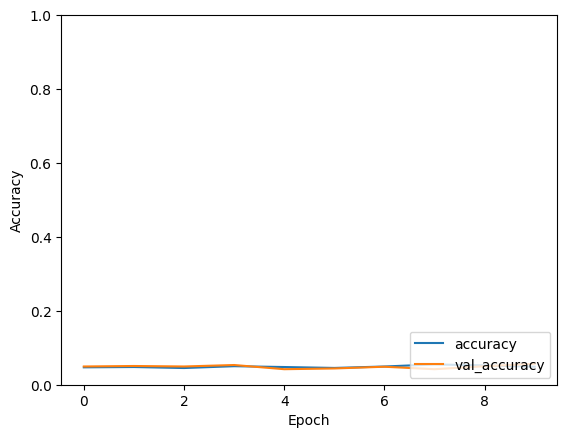

In [ ]:
plt.plot(LeNet_history_1.history['accuracy'], label='accuracy')
plt.plot(LeNet_history_1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

LeNet_test_loss, LeNet_test_acc = LeNet_model_1.evaluate(x_test,  y_test_to20, verbose=2)

63/63 - 1s - loss: 2.2392 - accuracy: 0.3065 - 967ms/epoch - 15ms/step


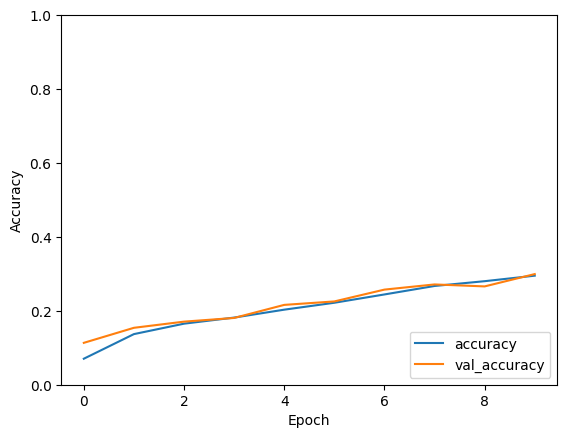

In [ ]:
plt.plot(LeNet_history_2.history['accuracy'], label='accuracy')
plt.plot(LeNet_history_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

LeNet_test_loss, LeNet_test_acc = LeNet_model_2.evaluate(x_test,  y_test_to20, verbose=2)

63/63 - 5s - loss: 2.0038 - accuracy: 0.3810 - 5s/epoch - 74ms/step


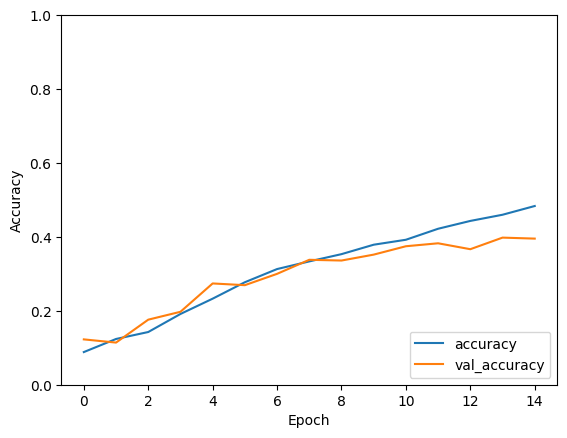

In [ ]:
plt.plot(AlexNet_history_1.history['accuracy'], label='accuracy')
plt.plot(AlexNet_history_1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

AlexNet_test_loss, AlexNet_test_acc = AlexNet_model_1.evaluate(x_test,  y_test_to20, verbose=2)

63/63 - 4s - loss: 2.5447 - accuracy: 0.3595 - 4s/epoch - 65ms/step


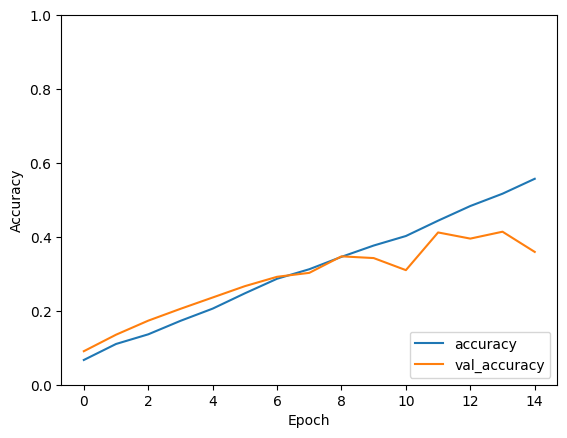

In [ ]:
plt.plot(AlexNet_history_2.history['accuracy'], label='accuracy')
plt.plot(AlexNet_history_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

AlexNet_test_loss, AlexNet_test_acc = AlexNet_model_2.evaluate(x_test,  y_test_to20, verbose=2)

63/63 - 9s - loss: 2.8128 - accuracy: 0.4885 - 9s/epoch - 136ms/step


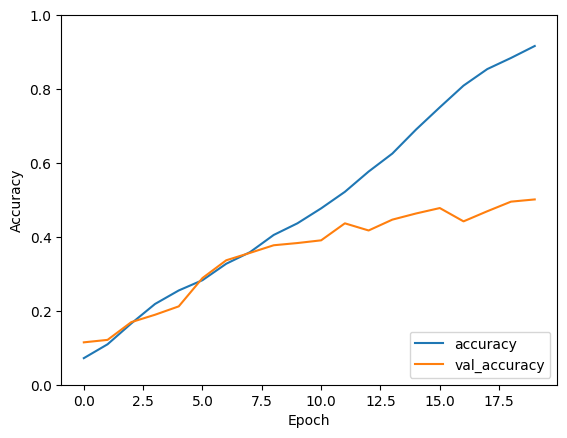

In [ ]:
plt.plot(VGG_history_1.history['accuracy'], label='accuracy')
plt.plot(VGG_history_1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

VGG_test_loss, VGG_test_acc = VGG_model_1.evaluate(x_test,  y_test_to20, verbose=2)

63/63 - 9s - loss: 2.9791 - accuracy: 0.5185 - 9s/epoch - 136ms/step


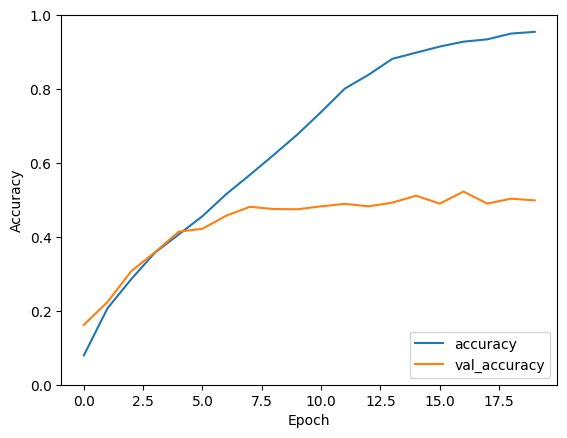

In [ ]:
plt.plot(VGG_history_2.history['accuracy'], label='accuracy')
plt.plot(VGG_history_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

VGG_test_loss, VGG_test_acc = VGG_model_2.evaluate(x_test,  y_test_to20, verbose=2)

63/63 - 2s - loss: 2.4240 - accuracy: 0.4960 - 2s/epoch - 33ms/step


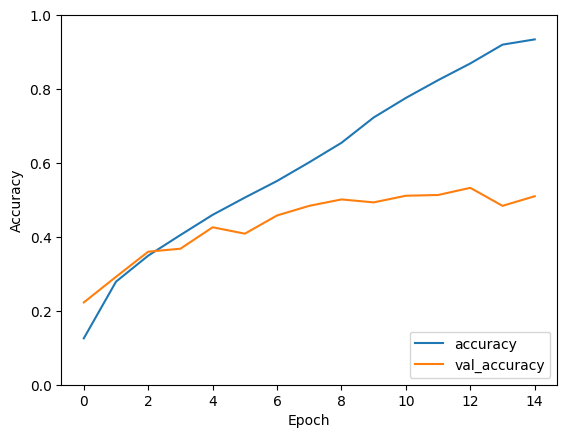

In [ ]:
plt.plot(MyCNN_history_1.history['accuracy'], label='accuracy')
plt.plot(MyCNN_history_1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

MyCNN__test_loss, MyCNN__test_acc = MyCNN_model_1.evaluate(x_test,  y_test_to20, verbose=2)

63/63 - 2s - loss: 2.1074 - accuracy: 0.4940 - 2s/epoch - 33ms/step


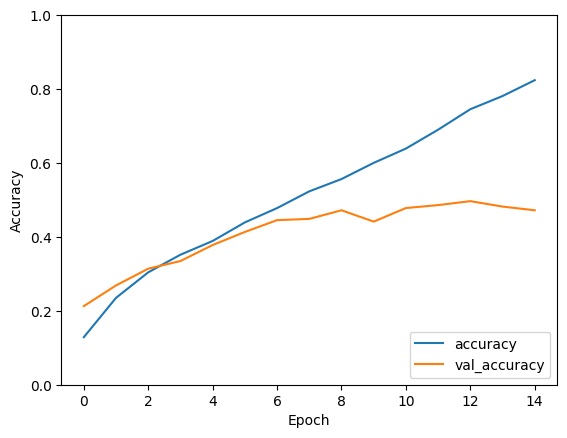

In [ ]:
plt.plot(MyCNN_history_2.history['accuracy'], label='accuracy')
plt.plot(MyCNN_history_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

MyCNN__test_loss, MyCNN__test_acc = MyCNN_model_2.evaluate(x_test,  y_test_to20, verbose=2)

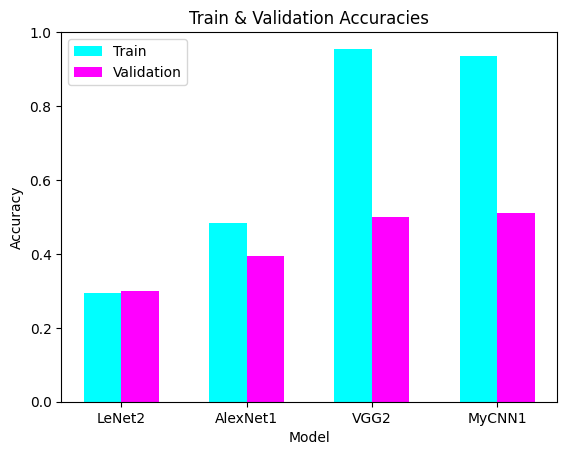

In [ ]:
fig=plt.figure()
x=np.arange(4)
ytrain=[0.2951,0.4835,0.9547,0.9344]
yval=[0.2993,0.3953,0.4987,0.51]
width=0.3
plt.bar(x-0.15,ytrain,width,color='cyan')
plt.bar(x+0.15,yval,width,color='magenta')
plt.xlabel('Model')
plt.xticks(x, ['LeNet2','AlexNet1','VGG2','MyCNN1'])
plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.title('Train & Validation Accuracies')
plt.legend(['Train','Validation'])
fig.show()

Παραατηρούμε ότι γενικά η ορθότητα εκπαίδευσης είναι μεγαλύτερη από την ορθότητα επαλήθευσης. Αυτό οφείλεται στο φαινόμενο της υπερπροσαρμογής.

Αξιολόγηση αποτελεσμάτων όσον αφορά:
- Πλήθος Δεδομένων/Κλάσεων: Όσο περισσότερα δεδομένα έχουμε, τόσο καλύτερα εκπαιδεύτεται το μοντέλο, αφού μπορεί να αναγνωρίσει διάφορες μορφές ενός στοιχείου που ανήκει σε μια κατηγορία. Ωστόσο, όσο περισσότερες είναι οι κλάσεις στις οποίες πρέπει να διαχωρίσουμε τα δεδομένα, τόσο μειώνεται η ορθότητα, αφού το μοντέλο πρέπει να αποφασίσει μεταξύ περισσότερων κλάσεων, και άρα η πιθανότητα σφάλματος αυξάνεται.

- Αλγόριθμος Βελτιστοποίησης (Optimizer): Παρατηρούμε ότι διαφορετικοί optimizers έχουν καλύτερα αποτελέσαμτα σε διαφορετικά μοντέλα. Για παράδειγμα, ο optimizer Adam είναι η καλύτερη επιλογή για το AlexNet, ενώ ο optimizer RMSprop για το VGG. Έτσι καταλαβαίνουμε ότι δεν υπάρχει κάποιος συγκεκριμένος τρόπος να πούμε ποιος είναι ο καλύτερος optimizer.

- Batch Size: Με μικρότερα batch sizes, η εκπαίδευση απαιτεί λιγότερη μνήμη, και τελικά το μοντέλο εκπαιδεύεται καλύτερα, γιατί τα βάρη ανανεώνονται περισσότερες φορές. Παράλληλα όμως, χρειάζεται περισσότερο χρόνο κατά την εκπαίδευση, αφού γίνονται περισσότερα forward και backward passes, και ο υπολογισμός του gradient δεν είναι τόσο ακριβής, μιας και χρησιμοποιούμε λιγότερα δείγματα στον υπολογισμό του.

Model|Test Accuracy
---|---
LeNet1|0.05
LeNet2|0.3065
AlexNet1|0.3810
AlexNet2|0.3595
VGG1|0.4885
VGG2|0.5185
MyCNN1|0.4960
MyCNN2|0.4940

Παρατηρούμε ότι όλα τα μοντέλα έχουν παρόμοια test ορ΄θτητα με την αντίστοιχη ορθότητα επαλήθευσης. Επίσης τα μοντέλα με τα καλύτερα αποτελέσματα είναι το AlexNet και το MyCNN.


### Ερώτημα 2
---
#### Βήμα 1: Έλεγχος υπερεκπαίδευσης

Για τον καλύτερο συνδυασμό που λάβατε από το Ερώτημα 1 για μοντέλο σας  (**MyCNN**) και μόνο, δοκιμάστε διάφορους συνδυασμούς των ακόλουθων τεχνικών για τον έλεγχο της υπερεκπαίδευσης (overfitting), όπως:

- Dropout ([Dropout](https://www.tensorflow.org/tutorials/images/classification#dropout))

- Επαύξηση δεδομένων ([Data augmentation](https://www.tensorflow.org/tutorials/images/classification#data_augmentation), [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#class_imagedatagenerator))

\\
, ώστε το μοντέλο σας να γενικεύει καλύτερα.

---
#### Βήμα 2: Αξιολόγηση
Αξιολογήστε της ορθότητας για το validation και το test set σας.

Βήμα 1: Έλεγχος υπερεκπαίδευσης

Dropout

In [ ]:
def dropout(dropout_val):
  dropout_layer = models.Sequential()
  dropout_layer.add(layers.Dropout(dropout_val))
  return dropout_layer

Επαύξηση δεδομένων (Data augmentation, ImageDataGenerator)

In [ ]:
from tensorflow import keras

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(32, 32, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Νέο Μοντέλο

In [ ]:
def MyCNN_dropout_data_aug(dropout_val,data_augment):
  model = models.Sequential()
  if(data_augment):
    model.add(data_augmentation)
  model.add(layers.Conv2D(filters=96, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPool2D(pool_size=3, strides=2))
  model.add(layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
  model.add(layers.MaxPool2D(pool_size=3, strides=2))
  model.add(layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'))
  model.add(layers.MaxPool2D(pool_size=3, strides=2))
  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation='relu'))
  model.add(dropout(dropout_val))
  model.add(layers.Dense(20))
  return model

X = tf.random.uniform((1, 32, 32, 3))
for layer in MyCNN_dropout_data_aug(0.5,True).layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Sequential output shape: 	 (1, 32, 32, 3)
Conv2D output shape: 	 (1, 32, 32, 96)
MaxPooling2D output shape: 	 (1, 15, 15, 96)
Conv2D output shape: 	 (1, 15, 15, 256)
MaxPooling2D output shape: 	 (1, 7, 7, 256)
Conv2D output shape: 	 (1, 7, 7, 384)
MaxPooling2D output shape: 	 (1, 3, 3, 384)
Flatten output shape: 	 (1, 3456)
Dense output shape: 	 (1, 4096)
Sequential output shape: 	 (1, 4096)
Dense output shape: 	 (1, 20)


### Δοκιμές

Χωρίς data augmentation και dropout = 0.1

In [ ]:
MyCNN_test_1 = MyCNN_dropout_data_aug(0.1, False)

MyCNN_test_1.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

MyCNN_history_test_1 = MyCNN_test_1.fit(x_train, y_train_to20, epochs=15, batch_size=128,
                    validation_data=(x_val, y_val_to20))

Epoch 1/15
67/67 [==============================] - 117s 2s/step - loss: 2.7577 - accuracy: 0.1348 - val_loss: 2.4269 - val_accuracy: 0.2293
Epoch 2/15
67/67 [==============================] - 113s 2s/step - loss: 2.2840 - accuracy: 0.2864 - val_loss: 2.1625 - val_accuracy: 0.3033
Epoch 3/15
67/67 [==============================] - 115s 2s/step - loss: 2.0237 - accuracy: 0.3596 - val_loss: 1.9601 - val_accuracy: 0.3607
Epoch 4/15
67/67 [==============================] - 112s 2s/step - loss: 1.7948 - accuracy: 0.4300 - val_loss: 1.7078 - val_accuracy: 0.4587
Epoch 5/15
67/67 [==============================] - 114s 2s/step - loss: 1.6186 - accuracy: 0.4871 - val_loss: 1.6729 - val_accuracy: 0.4753
Epoch 6/15
67/67 [==============================] - 114s 2s/step - loss: 1.4874 - accuracy: 0.5371 - val_loss: 1.5740 - val_accuracy: 0.4927
Epoch 7/15
67/67 [==============================] - 112s 2s/step - loss: 1.3027 - accuracy: 0.5845 - val_loss: 1.5476 - val_accuracy: 0.5173
Epoch 8/15
67

Με data augmentation και dropout = 0.1

In [ ]:
MyCNN_test_2 = MyCNN_dropout_data_aug(0.1, True)

MyCNN_test_2.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

MyCNN_history_test_2 = MyCNN_test_2.fit(x_train, y_train_to20, epochs=15, batch_size=128,
                    validation_data=(x_val, y_val_to20))

Epoch 1/15
67/67 [==============================] - 115s 2s/step - loss: 2.7849 - accuracy: 0.1275 - val_loss: 2.5086 - val_accuracy: 0.1993
Epoch 2/15
67/67 [==============================] - 113s 2s/step - loss: 2.3858 - accuracy: 0.2529 - val_loss: 2.1891 - val_accuracy: 0.3233
Epoch 3/15
67/67 [==============================] - 112s 2s/step - loss: 2.2143 - accuracy: 0.3042 - val_loss: 2.0592 - val_accuracy: 0.3413
Epoch 4/15
67/67 [==============================] - 114s 2s/step - loss: 2.0399 - accuracy: 0.3593 - val_loss: 1.9175 - val_accuracy: 0.3973
Epoch 5/15
67/67 [==============================] - 112s 2s/step - loss: 1.9569 - accuracy: 0.3841 - val_loss: 1.9140 - val_accuracy: 0.3940
Epoch 6/15
67/67 [==============================] - 112s 2s/step - loss: 1.8389 - accuracy: 0.4252 - val_loss: 1.7716 - val_accuracy: 0.4327
Epoch 7/15
67/67 [==============================] - 113s 2s/step - loss: 1.7375 - accuracy: 0.4544 - val_loss: 1.7700 - val_accuracy: 0.4433
Epoch 8/15
67

Χωρίς data augmentation και dropout = 0.3

In [ ]:
MyCNN_test_3 = MyCNN_dropout_data_aug(0.3, False)

MyCNN_test_3.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

MyCNN_history_test_3 = MyCNN_test_3.fit(x_train, y_train_to20, epochs=15, batch_size=128,
                    validation_data=(x_val, y_val_to20))

Epoch 1/15
67/67 [==============================] - 117s 2s/step - loss: 2.7515 - accuracy: 0.1393 - val_loss: 2.4857 - val_accuracy: 0.2027
Epoch 2/15
67/67 [==============================] - 113s 2s/step - loss: 2.2938 - accuracy: 0.2842 - val_loss: 2.0848 - val_accuracy: 0.3360
Epoch 3/15
67/67 [==============================] - 115s 2s/step - loss: 2.0119 - accuracy: 0.3719 - val_loss: 1.9652 - val_accuracy: 0.3567
Epoch 4/15
67/67 [==============================] - 114s 2s/step - loss: 1.8079 - accuracy: 0.4266 - val_loss: 1.8844 - val_accuracy: 0.4200
Epoch 5/15
67/67 [==============================] - 114s 2s/step - loss: 1.6482 - accuracy: 0.4756 - val_loss: 1.7124 - val_accuracy: 0.4533
Epoch 6/15
67/67 [==============================] - 115s 2s/step - loss: 1.4823 - accuracy: 0.5226 - val_loss: 1.5582 - val_accuracy: 0.5027
Epoch 7/15
67/67 [==============================] - 114s 2s/step - loss: 1.3078 - accuracy: 0.5816 - val_loss: 1.5700 - val_accuracy: 0.5187
Epoch 8/15
67

Με data augmentation και dropout = 0.3

In [ ]:
MyCNN_test_4 = MyCNN_dropout_data_aug(0.3, True)

MyCNN_test_4.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

MyCNN_history_test_4 = MyCNN_test_4.fit(x_train, y_train_to20, epochs=15, batch_size=128,
                    validation_data=(x_val, y_val_to20))

Epoch 1/15
67/67 [==============================] - 114s 2s/step - loss: 2.6976 - accuracy: 0.1527 - val_loss: 2.4079 - val_accuracy: 0.2293
Epoch 2/15
67/67 [==============================] - 113s 2s/step - loss: 2.3343 - accuracy: 0.2734 - val_loss: 2.1936 - val_accuracy: 0.2860
Epoch 3/15
67/67 [==============================] - 112s 2s/step - loss: 2.1238 - accuracy: 0.3294 - val_loss: 2.0806 - val_accuracy: 0.3460
Epoch 4/15
67/67 [==============================] - 113s 2s/step - loss: 1.9690 - accuracy: 0.3794 - val_loss: 2.0611 - val_accuracy: 0.3593
Epoch 5/15
67/67 [==============================] - 112s 2s/step - loss: 1.8644 - accuracy: 0.4161 - val_loss: 1.7626 - val_accuracy: 0.4413
Epoch 6/15
67/67 [==============================] - 113s 2s/step - loss: 1.7512 - accuracy: 0.4500 - val_loss: 1.7911 - val_accuracy: 0.4440
Epoch 7/15
67/67 [==============================] - 124s 2s/step - loss: 1.6838 - accuracy: 0.4667 - val_loss: 1.7917 - val_accuracy: 0.4273
Epoch 8/15
67

Βήμα 2: Αξιολόγηση

Ως καλύτερη επιλέχθηκε η 3η δοκιμή που κάναμε χωρίς data augmentation και dropout = 0.3.

Όπως ήταν αναμενόμενο, η προσθήκη dropout βελτίωσε το μοντέλο μας, αφου αποτελεί τρόπο να εισάγουμε regularization στο μοντέλο, και άρα μεγαλύτερη γενίκευση. Ο τρόπος που δουλεύει είναι να αγνοεί με πιθανότητα κάποιους νευρώνες κατά την εκπαίδευση, και έτσι να αναγκάζει το μοντέλο να μην δημιουργεί "σημαντικούς" νευρώνες για την εύρεση κάποιων χαρακτηριστηκών, και έτσι αποφεύγεται και η υπερπροσαρμογή.

Συνήθως η επάυξηση δεδομένων εκπαίδευσης φέρει άυξηση της ορθότητας, ωστόσο στην περίπτωσή μας, φαίνεται να μην πρόσφερε ιδιαίτερα.

63/63 - 6s - loss: 1.9190 - accuracy: 0.5610 - 6s/epoch - 90ms/step


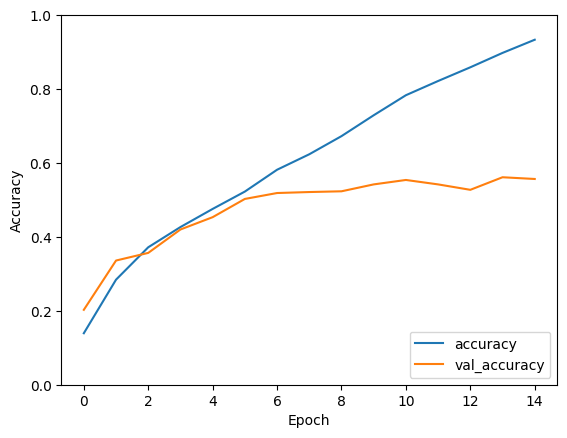

In [ ]:
plt.plot(MyCNN_history_test_3.history['accuracy'], label='accuracy')
plt.plot(MyCNN_history_test_3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

MyCNN__test_loss, MyCNN__test_acc = MyCNN_test_3.evaluate(x_test,  y_test_to20, verbose=2)

Validation Accuracy|Test Accuracy
---|---
0.5467|0.5610

Παρατηρούμε ότι με εισαγωγή dropout η ακρίβεια του μοντέλου αυξήθηκε από την τιμή 0.4960 (όπως υπολογίστηκε στο προηγούμενο ερώτημα).

### Ερώτημα 3
---
#### Βήμα 1: Μεταφορά γνώσης
Εφαρμόστε μεταφορά γνώσης (transfer learning) στο δικό σας μοντέλο (**MyCNN**), που αξιολογήσατε ως καλύτερο προς την ορθότητα στην αντιμετώπιση της υπερεκπαίδεσης.

Για το transfer learning, επιλέξτε το [VGG19](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19)  και το [EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0) για μεταφορά μάθησης.

1. "Παγώστε" τη συνελικτική βάση και εκπαιδεύστε την κεφαλή ταξινόμησης (classification head - σημαία trainable = False).  

2. Εκπαιδέστε μόνο ένα ποσοστό των επιπέδων, το οποίο βρίσκεται προς την έξοδο του δικτύου. Οι σημαίες trainable εδώ θα πρέπει να οριστούν ανά επίπεδο.

3. Αξιολογήστε τα αποτελέσματά σας, βάσει της ορθότητας του validation set και του test set σας.

1."Παγώστε" τη συνελικτική βάση και εκπαιδεύστε την κεφαλή ταξινόμησης (classification head - σημαία trainable = False).

In [ ]:
pretrained_model_VGG19 = tf.keras.applications.VGG19(include_top=False, input_shape=(32, 32, 3))
pretrained_model_EfficientNetB0 = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(32, 32, 3))
pretrained_model_VGG19.trainable = False
pretrained_model_EfficientNetB0.trainable = False

Ορίζουμε το νέο μοντέλο που θα χρησιμοποιήση το pretrained μοντέλο

In [ ]:
def MyCNN_transfer_learning(dropout_val,data_augment,pretrained_model):
  model = models.Sequential()
  model.add(pretrained_model)
  model.add(layers.Flatten())
  model.add(layers.Dense(200, activation='relu'))
  model.add(dropout(dropout_val))
  model.add(layers.Dense(20))
  return model

In [ ]:
X = tf.random.uniform((1, 32, 32, 3))
for layer in MyCNN_transfer_learning(0.5,True,pretrained_model_VGG19).layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Functional output shape: 	 (1, 1, 1, 512)
Flatten output shape: 	 (1, 512)
Dense output shape: 	 (1, 200)
Sequential output shape: 	 (1, 200)
Dense output shape: 	 (1, 20)


In [ ]:
X = tf.random.uniform((1, 32, 32, 3))
for layer in MyCNN_transfer_learning(0.5,True,pretrained_model_EfficientNetB0).layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Functional output shape: 	 (1, 1, 1, 1280)
Flatten output shape: 	 (1, 1280)
Dense output shape: 	 (1, 200)
Sequential output shape: 	 (1, 200)
Dense output shape: 	 (1, 20)


Μεταγλώτιση και εκπαίδευση

VGG19

In [ ]:
MyCNN_model_VGG19_transfer_learning = MyCNN_transfer_learning(0.3, False,pretrained_model_VGG19)

MyCNN_model_VGG19_transfer_learning.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

MyCNN_VGG19_history_transfer_learning = MyCNN_model_VGG19_transfer_learning.fit(x_train, y_train_to20, epochs=30, batch_size=128,
                    validation_data=(x_val, y_val_to20))

Epoch 1/30
67/67 [==============================] - 6s 54ms/step - loss: 2.5675 - accuracy: 0.2240 - val_loss: 2.1962 - val_accuracy: 0.3267
Epoch 2/30
67/67 [==============================] - 2s 26ms/step - loss: 2.1624 - accuracy: 0.3365 - val_loss: 2.0588 - val_accuracy: 0.3640
Epoch 3/30
67/67 [==============================] - 2s 27ms/step - loss: 2.0444 - accuracy: 0.3672 - val_loss: 1.9881 - val_accuracy: 0.3887
Epoch 4/30
67/67 [==============================] - 2s 27ms/step - loss: 1.9550 - accuracy: 0.3942 - val_loss: 1.9233 - val_accuracy: 0.3987
Epoch 5/30
67/67 [==============================] - 2s 28ms/step - loss: 1.8901 - accuracy: 0.4152 - val_loss: 1.8958 - val_accuracy: 0.4107
Epoch 6/30
67/67 [==============================] - 2s 28ms/step - loss: 1.8374 - accuracy: 0.4282 - val_loss: 1.8795 - val_accuracy: 0.4173
Epoch 7/30
67/67 [==============================] - 2s 28ms/step - loss: 1.8011 - accuracy: 0.4387 - val_loss: 1.8590 - val_accuracy: 0.4120
Epoch 8/30
67

EfficientNetB0

In [ ]:
MyCNN_model_EfficientNetB0_transfer_learning = MyCNN_transfer_learning(0.3, False,pretrained_model_EfficientNetB0)

MyCNN_model_EfficientNetB0_transfer_learning.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

MyCNN_EfficientNetB0_history_transfer_learning = MyCNN_model_EfficientNetB0_transfer_learning.fit(x_train, y_train_to20, epochs=20, batch_size=128,
                    validation_data=(x_val, y_val_to20))

Epoch 1/20
67/67 [==============================] - 10s 57ms/step - loss: 3.0103 - accuracy: 0.0526 - val_loss: 2.9995 - val_accuracy: 0.0500
Epoch 2/20
67/67 [==============================] - 1s 14ms/step - loss: 2.9958 - accuracy: 0.0484 - val_loss: 2.9961 - val_accuracy: 0.0453
Epoch 3/20
67/67 [==============================] - 1s 14ms/step - loss: 2.9958 - accuracy: 0.0458 - val_loss: 2.9962 - val_accuracy: 0.0453
Epoch 4/20
67/67 [==============================] - 1s 13ms/step - loss: 2.9958 - accuracy: 0.0511 - val_loss: 2.9965 - val_accuracy: 0.0453
Epoch 5/20
67/67 [==============================] - 1s 14ms/step - loss: 2.9958 - accuracy: 0.0491 - val_loss: 2.9965 - val_accuracy: 0.0447
Epoch 6/20
67/67 [==============================] - 1s 14ms/step - loss: 2.9959 - accuracy: 0.0475 - val_loss: 2.9967 - val_accuracy: 0.0453
Epoch 7/20
67/67 [==============================] - 1s 14ms/step - loss: 2.9957 - accuracy: 0.0511 - val_loss: 2.9968 - val_accuracy: 0.0420
Epoch 8/20
6

2.Εκπαιδέστε μόνο ένα ποσοστό των επιπέδων, το οποίο βρίσκεται προς την έξοδο του δικτύου. Οι σημαίες trainable εδώ θα πρέπει να οριστούν ανά επίπεδο.

In [ ]:
pretrained_model_VGG19_2 = tf.keras.applications.VGG19(input_shape=(32,32,3), include_top=False)
pretrained_model_EfficientNetB0_2 = tf.keras.applications.VGG19(input_shape=(32,32,3), include_top=False)
pretrained_model_VGG19.trainable = False
pretrained_model_EfficientNetB0.trainable = False

print("VGG19:")

X = tf.random.uniform((1, 32, 32, 3))
i = 1
for layer in pretrained_model_VGG19_2.layers:
    X = layer(X)
    print(i,layer.__class__.__name__, 'output shape: \t', X.shape)
    i+=1

print("EfficientNetB0:")

X = tf.random.uniform((1, 32, 32, 3))
i = 1
for layer in pretrained_model_EfficientNetB0_2.layers:
    X = layer(X)
    print(i,layer.__class__.__name__, 'output shape: \t', X.shape)
    i+=1

VGG19:
1 InputLayer output shape: 	 (1, 32, 32, 3)
2 Conv2D output shape: 	 (1, 32, 32, 64)
3 Conv2D output shape: 	 (1, 32, 32, 64)
4 MaxPooling2D output shape: 	 (1, 16, 16, 64)
5 Conv2D output shape: 	 (1, 16, 16, 128)
6 Conv2D output shape: 	 (1, 16, 16, 128)
7 MaxPooling2D output shape: 	 (1, 8, 8, 128)
8 Conv2D output shape: 	 (1, 8, 8, 256)
9 Conv2D output shape: 	 (1, 8, 8, 256)
10 Conv2D output shape: 	 (1, 8, 8, 256)
11 Conv2D output shape: 	 (1, 8, 8, 256)
12 MaxPooling2D output shape: 	 (1, 4, 4, 256)
13 Conv2D output shape: 	 (1, 4, 4, 512)
14 Conv2D output shape: 	 (1, 4, 4, 512)
15 Conv2D output shape: 	 (1, 4, 4, 512)
16 Conv2D output shape: 	 (1, 4, 4, 512)
17 MaxPooling2D output shape: 	 (1, 2, 2, 512)
18 Conv2D output shape: 	 (1, 2, 2, 512)
19 Conv2D output shape: 	 (1, 2, 2, 512)
20 Conv2D output shape: 	 (1, 2, 2, 512)
21 Conv2D output shape: 	 (1, 2, 2, 512)
22 MaxPooling2D output shape: 	 (1, 1, 1, 512)
EfficientNetB0:
1 InputLayer output shape: 	 (1, 32, 32, 3)

Αλλαγή σημαίας trainable σε True για τα επίπεδα 10-22 των μοντέλων.

In [ ]:
i = 1
for layer in pretrained_model_VGG19_2.layers:
  if(i<10):
    layer.trainable = False
  i += 1

In [ ]:
i = 1
for layer in pretrained_model_EfficientNetB0_2.layers:
  if(i<10):
    layer.trainable = False
  print(i,layer.trainable)
  i += 1

1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True


Ορίζουμε το νέο μοντέλο που θα χρησιμοποιήση το pretrained μοντέλο 2

In [ ]:
def MyCNN_transfer_learning_2(dropout_val,data_augment,pretrained_model):
  model = models.Sequential()
  model.add(pretrained_model)
  model.add(layers.Flatten())
  model.add(layers.Dense(200, activation='relu'))
  model.add(dropout(dropout_val))
  model.add(layers.Dense(20))
  return model

In [ ]:
X = tf.random.uniform((1, 32, 32, 3))
for layer in MyCNN_transfer_learning_2(0.3, False,pretrained_model_VGG19_2).layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Functional output shape: 	 (1, 1, 1, 512)
Flatten output shape: 	 (1, 512)
Dense output shape: 	 (1, 200)
Sequential output shape: 	 (1, 200)
Dense output shape: 	 (1, 20)


Μεταγλώτιση και εκπαίδευση

VGG19

In [ ]:
MyCNN_model_VGG19_transfer_learning_2 = MyCNN_transfer_learning_2(0.3,False,pretrained_model_VGG19_2)

MyCNN_model_VGG19_transfer_learning_2.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

MyCNN_VGG19_history_transfer_learning_2 = MyCNN_model_VGG19_transfer_learning_2.fit(x_train, y_train_to20, epochs=30, batch_size=128,
                    validation_data=(x_val, y_val_to20))

Epoch 1/30
67/67 [==============================] - 9s 60ms/step - loss: 2.9441 - accuracy: 0.0787 - val_loss: 2.7739 - val_accuracy: 0.0900
Epoch 2/30
67/67 [==============================] - 4s 57ms/step - loss: 2.7614 - accuracy: 0.1091 - val_loss: 2.6379 - val_accuracy: 0.1340
Epoch 3/30
67/67 [==============================] - 4s 56ms/step - loss: 2.6652 - accuracy: 0.1352 - val_loss: 2.6563 - val_accuracy: 0.1240
Epoch 4/30
67/67 [==============================] - 4s 56ms/step - loss: 2.5675 - accuracy: 0.1706 - val_loss: 2.4136 - val_accuracy: 0.2040
Epoch 5/30
67/67 [==============================] - 4s 57ms/step - loss: 2.4559 - accuracy: 0.1946 - val_loss: 2.3289 - val_accuracy: 0.2353
Epoch 6/30
67/67 [==============================] - 4s 57ms/step - loss: 2.3592 - accuracy: 0.2278 - val_loss: 2.3272 - val_accuracy: 0.2327
Epoch 7/30
67/67 [==============================] - 4s 57ms/step - loss: 2.2969 - accuracy: 0.2528 - val_loss: 2.3261 - val_accuracy: 0.2480
Epoch 8/30
67

EfficientNetB0

In [ ]:
MyCNN_model_EfficientNetB0_transfer_learning_2 = MyCNN_transfer_learning_2(0.3,False,pretrained_model_EfficientNetB0_2)

MyCNN_model_EfficientNetB0_transfer_learning_2.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

MyCNN_EfficientNetB0_history_transfer_learning_2 = MyCNN_model_EfficientNetB0_transfer_learning_2.fit(x_train, y_train_to20, epochs=20, batch_size=128,
                    validation_data=(x_val, y_val_to20))

Epoch 1/20
67/67 [==============================] - 8s 59ms/step - loss: 3.0235 - accuracy: 0.0499 - val_loss: 2.9958 - val_accuracy: 0.0453
Epoch 2/20
67/67 [==============================] - 4s 56ms/step - loss: 2.9960 - accuracy: 0.0501 - val_loss: 2.9961 - val_accuracy: 0.0453
Epoch 3/20
67/67 [==============================] - 4s 56ms/step - loss: 2.9959 - accuracy: 0.0471 - val_loss: 2.9963 - val_accuracy: 0.0447
Epoch 4/20
67/67 [==============================] - 4s 55ms/step - loss: 2.9958 - accuracy: 0.0499 - val_loss: 2.9965 - val_accuracy: 0.0420
Epoch 5/20
67/67 [==============================] - 4s 55ms/step - loss: 2.9958 - accuracy: 0.0521 - val_loss: 2.9967 - val_accuracy: 0.0447
Epoch 6/20
67/67 [==============================] - 4s 56ms/step - loss: 2.9959 - accuracy: 0.0448 - val_loss: 2.9969 - val_accuracy: 0.0420
Epoch 7/20
67/67 [==============================] - 4s 56ms/step - loss: 2.9958 - accuracy: 0.0494 - val_loss: 2.9969 - val_accuracy: 0.0447
Epoch 8/20
67

### Αξιολόγηση μοντέλων

63/63 - 1s - loss: 1.7450 - accuracy: 0.4485 - 1s/epoch - 21ms/step


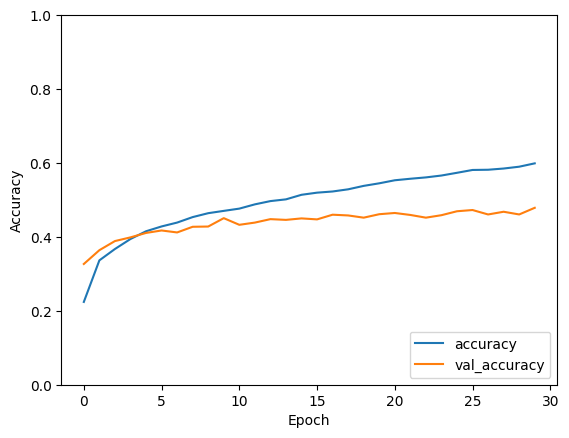

In [ ]:
plt.plot(MyCNN_VGG19_history_transfer_learning.history['accuracy'], label='accuracy')
plt.plot(MyCNN_VGG19_history_transfer_learning.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

MyCNN__test_loss, MyCNN__test_acc = MyCNN_model_VGG19_transfer_learning.evaluate(x_test,  y_test_to20, verbose=2)

63/63 - 1s - loss: 2.9959 - accuracy: 0.0500 - 577ms/epoch - 9ms/step


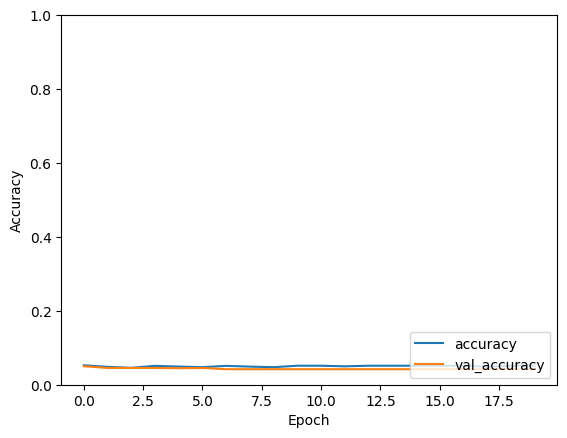

In [ ]:
plt.plot(MyCNN_EfficientNetB0_history_transfer_learning.history['accuracy'], label='accuracy')
plt.plot(MyCNN_EfficientNetB0_history_transfer_learning.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

MyCNN__test_loss, MyCNN__test_acc = MyCNN_model_EfficientNetB0_transfer_learning.evaluate(x_test,  y_test_to20, verbose=2)

63/63 - 1s - loss: 1.9782 - accuracy: 0.4780 - 577ms/epoch - 9ms/step


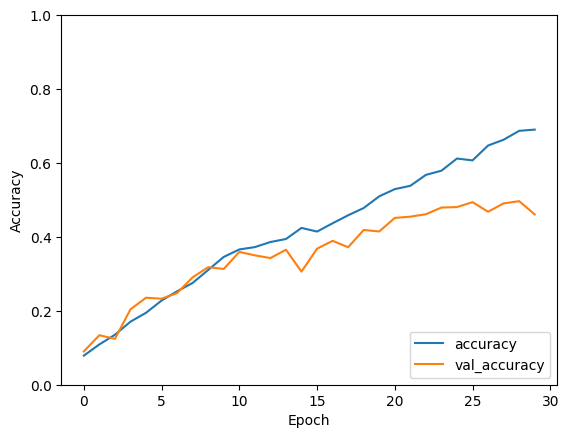

In [ ]:
plt.plot(MyCNN_VGG19_history_transfer_learning_2.history['accuracy'], label='accuracy')
plt.plot(MyCNN_VGG19_history_transfer_learning_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

MyCNN__test_loss, MyCNN__test_acc = MyCNN_model_VGG19_transfer_learning_2.evaluate(x_test,  y_test_to20, verbose=2)

63/63 - 1s - loss: 2.9958 - accuracy: 0.0500 - 582ms/epoch - 9ms/step


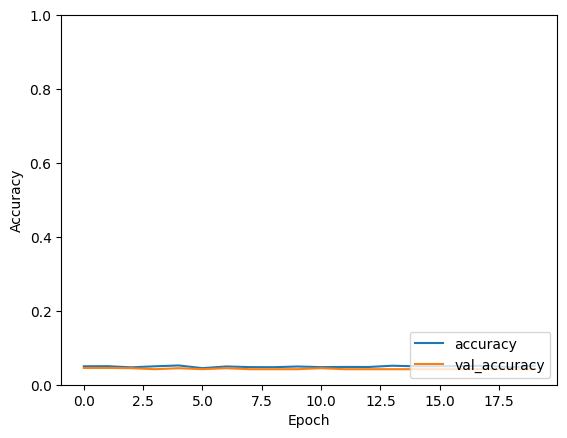

In [ ]:
plt.plot(MyCNN_EfficientNetB0_history_transfer_learning_2.history['accuracy'], label='accuracy')
plt.plot(MyCNN_EfficientNetB0_history_transfer_learning_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

MyCNN__test_loss, MyCNN__test_acc = MyCNN_model_EfficientNetB0_transfer_learning_2.evaluate(x_test,  y_test_to20, verbose=2)

Model|Validation Accuracy|Test Accuracy
---|---|---
1st Pretrained VGG19|0.4787|0.4485
2nd Pretrained VGG19|0.4607|0.4780
1st Pretrained EfficientNetB0|0.0420|0.0500
2nd Pretrained EfficientNetB0|0.0420|0.0500

Χρησιμοποιώντας ένα ήδη εκπαιδευμένο μοντέλο κάνοντας μετά fine tuning μπορούμε πολύ πιο γρήγορα να πάρουμε ένα καλά εκπαιδευμένο μοντέλο, αφού εκμεταλλευόμαστε την κάπως "γενική" εκπαίδευσή του, και το προσαρμόζουμε στο δικό μας πρόβλημα. Αυτό φαίνεται και από την εκπαίδευση του πρώτου VGG19, όπου η ορθότητα επαλήθευσης μετά την πρώτη εποχή είναι 0.3640.

Ωστόσο, όπως δείχνουν οι τιμές ορθότητας στον παραπάνω πίνακα, τελικά στην περίπτωσσή μας δεν φάνηκαν κερδοφόρα, αφού κανένα δεν ξεπέρασε την οθότητα που επιτεύχθηκε στα προηγούμενα ερωτήματα (0.5610).

### Διαχείριση μνήμης (TFRecord)
Η φόρτωση δεδομένων με τον τρόπο που το κάναμε παραπάνω στο απλό παράδειγμα υλοποίησης είναι πολύ βολική αλλά δεν είναι αποτελεσματική ως προς τη διαχείριση της μνήμης. Συγκεκριμένα, με τον τρόπο αυτό, τα δεδομένα αποθηκεύονται απευθείας σε μεταβλητές, οι οποίες όλες μαζί καταλαμβάνουν τη RAM της CPU ή της GPU, κάτι που κάνει αδύνατη τη διαχείριση μεγάλων datasets ή τον μεταχηματισμό των δεδομένων όπως όταν κάνουμε αύξηση δεδομένων (data augmentation).

Για να παρακαμφθεί αυτό το πρόβλημα, υπάρχει η δυνατότητα της σειριοποίησης των δεδομένων (serialization) και της αποθήκευσής τους σε αρχεία μεσαίου μεγέθους (κάποιων MB) τα οποία μπορούν να αναγνωστούν γραμμικά.

Το φορμάτ TFRecord είναι ένα φορμάτ που επιτρέπει την αποθήκευση σειράς δυαδικών εγγραφών. Διαβάστε σχετικά για το [TFRecord and tf.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord) και [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data).

Σημειώστε ότι με τη μέθοδο αυτή θα πρέπει να γίνει import η `tensorflow_datasets` και να χρησιμοποιήσουμε την `tfds.load` ώστε να αποθηκευθεί το σύνολο δεδομένων σε αρχεία tfrecord στο δίσκο (δείτε [εδώ](https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb) ένα παράδειγμα). Φυσικά μπορούμε να μετατρέψουμε και τα πρωτογενή δεδομένα (raw data) του dataset όπως αρχεία jpg σε φορματ tfrecord όπως [εδώ](https://towardsdatascience.com/working-with-tfrecords-and-tf-train-example-36d111b3ff4d).
